## aoi classification  0-pass ，1-defect

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import random
import os,shutil

src_path="..\\tensorflow-classification\\dataset"

print(os.listdir(src_path))

#constant value
VALID_SPIT=0.2
IMAGE_SIZE=80
BATCH_SIZE=20

['defect', 'defect_clean', 'pass', 'test', 'test01', 'test_pass', 'train', 'train01']


### 載入data

In [13]:
label=[]
data=[]
counter=0
path="..\\tensorflow-classification\\dataset\\train01"
for file in os.listdir(path):
    image_data=cv2.imread(os.path.join(path,file), cv2.IMREAD_COLOR)
    image_data=cv2.resize(image_data,(IMAGE_SIZE,IMAGE_SIZE))
    if file.startswith("pass"):
        label.append(0)
    elif file.startswith("defect"):
        label.append(1)
    try:
        data.append(image_data/255)
    except:
        label=label[:len(label)-1]
    counter+=1
    if counter%200==0:
        print (counter," image data retreived")

data=np.array(data)
data=data.reshape((data.shape)[0],(data.shape)[1],(data.shape)[2],3)
label=np.array(label)
print (data.shape)
print (label.shape)

(180, 80, 80, 3)
(180,)


### split 20%

In [14]:
from sklearn.model_selection import train_test_split
train_data, valid_data, train_label, valid_label = train_test_split(
    data, label, test_size=0.2, random_state=42)
print(train_data.shape)
print(train_label.shape)
print(valid_data.shape)
print(valid_label.shape)

(144, 80, 80, 3)
(144,)
(36, 80, 80, 3)
(36,)


### use vgg model

In [1]:
from keras import applications
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(80, 80, 3))

vgg_model.summary()

C:\Users\nien\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0         
__________

### 建模

In [2]:
from keras import layers
from keras import models

In [3]:
from keras import applications
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(80, 80, 3))
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])
print(layer_dict)

{'input_2': <keras.engine.topology.InputLayer object at 0x0000021B32F84BE0>, 'block1_conv1': <keras.layers.convolutional.Conv2D object at 0x0000021B32F84CC0>, 'block1_conv2': <keras.layers.convolutional.Conv2D object at 0x0000021B32F84D68>, 'block1_pool': <keras.layers.pooling.MaxPooling2D object at 0x0000021B32F84E48>, 'block2_conv1': <keras.layers.convolutional.Conv2D object at 0x0000021B32FA03C8>, 'block2_conv2': <keras.layers.convolutional.Conv2D object at 0x0000021B32FA0C18>, 'block2_pool': <keras.layers.pooling.MaxPooling2D object at 0x0000021B198ECC50>, 'block3_conv1': <keras.layers.convolutional.Conv2D object at 0x0000021B198FBA20>, 'block3_conv2': <keras.layers.convolutional.Conv2D object at 0x0000021B1990F390>, 'block3_conv3': <keras.layers.convolutional.Conv2D object at 0x0000021B19925F28>, 'block3_pool': <keras.layers.pooling.MaxPooling2D object at 0x0000021B1993AF98>, 'block4_conv1': <keras.layers.convolutional.Conv2D object at 0x0000021B32F41940>, 'block4_conv2': <keras.l

In [4]:
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])
x = layer_dict['block5_pool'].output
x = layers.Flatten()(x)
x = layers.Dense(256, activation  = 'relu')(x)
y = layers.Dense(1, activation = 'sigmoid',name='out')(x)
model = models.Model(input=vgg_model.input, output=y)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


C:\Users\nien\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0         
__________

In [6]:
print(model.input)

Tensor("input_2:0", shape=(?, 80, 80, 3), dtype=float32)


In [7]:
print(model.output)

Tensor("out/Sigmoid:0", shape=(?, 1), dtype=float32)


In [23]:
model.get_layer('input_2')

In [11]:
import tensorflow as tf
tf_config = tf.ConfigProto()
tf_sess = tf.Session(config=tf_config)

In [13]:
tf_output = tf_sess.graph.get_tensor_by_name("out/Sigmoid:0")
print(tf_output)

Tensor("out/Sigmoid:0", shape=(?, 1), dtype=float32)


### training

In [9]:
from keras import backend as K
K.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
model.compile(loss='binary_crossentropy',optimizer=optimizers.adam(lr=1e-4),metrics=['acc'])

In [15]:
checkpoint_path = "check\\model.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [16]:
train_history=model.fit(train_data, train_label, epochs=20, batch_size=BATCH_SIZE)

Epoch 1/20
144/144 [==============================] - 7s 47ms/step - loss: 0.4183 - acc: 0.7986
Epoch 2/20
144/144 [==============================] - 1s 10ms/step - loss: 0.1058 - acc: 0.9514
Epoch 3/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0564 - acc: 0.9653
Epoch 4/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0337 - acc: 0.9931
Epoch 5/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0134 - acc: 0.9931
Epoch 6/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0067 - acc: 1.0000
Epoch 7/20
144/144 [==============================] - 1s 10ms/step - loss: 9.5362e-04 - acc: 1.0000
Epoch 8/20
144/144 [==============================] - 1s 10ms/step - loss: 1.0031e-04 - acc: 1.0000
Epoch 9/20
144/144 [==============================] - 1s 10ms/step - loss: 2.0747e-05 - acc: 1.0000
Epoch 10/20
144/144 [==============================] - 1s 10ms/step - loss: 1.1994e-05 - acc: 1.0000
Epoch 11/20
144/144 [==

### 儲存模型

In [17]:
model.save("model01.h5")

### 模糊矩陣

In [18]:
Y_pred = model.predict(valid_data)
predicted_label=np.round(Y_pred,decimals=2)

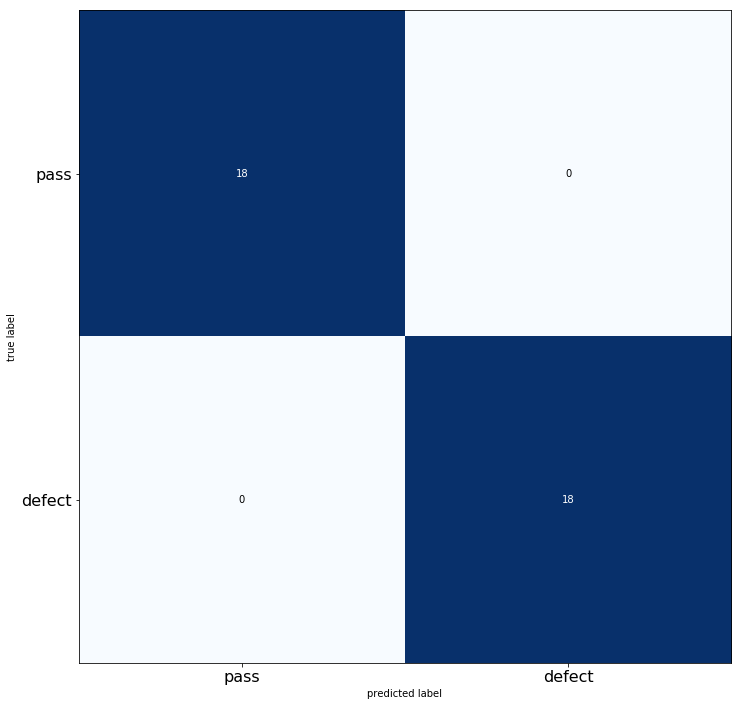

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix

# Get the confusion matrix

CM = confusion_matrix(valid_label, Y_pred.round())
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12, 12))
plt.xticks(range(2), ['pass', 'defect'], fontsize=16)
plt.yticks(range(2), ['pass', 'defect'], fontsize=16)
plt.show()

## 引入test data

In [20]:
import os
import cv2
import numpy as np
import pandas as pd

test_data=[]
id=[]
counter=0
IMAGE_SIZE=80

#for file in os.listdir("..\\tensorflow-classification\\dataset\\test_pass"):
for file in os.listdir("..\\tensorflow-classification\\dataset\\test01"):
    pic = "..\\tensorflow-classification\\dataset\\test01\\" + file
    image_data=cv2.imread(os.path.join(pic), cv2.IMREAD_COLOR)
    
    try:
        image_data=cv2.resize(image_data,(IMAGE_SIZE,IMAGE_SIZE))
        test_data.append(image_data/255)
        id.append((file.split("."))[0])
    except:
        print ("ek gaya")
    counter+=1


test_data=np.array(test_data)
print (test_data.shape)
test_data=test_data.reshape((test_data.shape)[0],(test_data.shape)[1],(test_data.shape)[2],3)
dataframe_output=pd.DataFrame({"id":id})

(18, 80, 80, 3)


In [21]:
predicted_labels=model.predict(test_data)
predicted_labels=np.round(predicted_labels,decimals=2)
labels=[1 if value>0.5 else 0 for value in predicted_labels]

In [22]:
dataframe_output["label"]=labels
print(dataframe_output)
dataframe_output.to_csv('result.csv')

        id  label
0   defect      1
1   defect      1
2   defect      1
3   defect      1
4   defect      1
5   defect      1
6   defect      1
7   defect      1
8   defect      1
9     pass      0
10    pass      0
11    pass      0
12    pass      0
13    pass      0
14    pass      0
15    pass      0
16    pass      0
17    pass      0


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(40):
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 2)
    plt.imshow(test_data[i])
#     plt.xlabel('label')
    plt.xlabel(dataframe_output["label"][i],fontsize=30)
    plt.title('0-pass,1-defect',fontsize=40)
    plt.show()

### 需要去csv檔案寫上答案

In [ ]:
import csv
import os
import numpy as np
correct = 0
with open('result.csv', newline='') as csvfile:    
    rows = csv.DictReader(csvfile)
    for row in rows:
        if row['label'] == row['answer']:
            correct += 1
        else:
            print(row['id'] + " 答案是:" + row['answer'] + " 誤判成: " + row['label'])
            
print("--------------------------------------")
print("準確率 ： %.8f" %(correct/(rows.line_num-1)))

## 使用model做驗證

In [17]:
from keras.models import load_model
import os
import cv2
import numpy as np
import pandas as pd
import csv
import os
import numpy as np

In [ ]:
model = load_model('model.h5')

test_data=[]
id=[]
counter=0
IMAGE_SIZE=80

for file in os.listdir("..\\tensorflow-classification\\dataset\\test_pass"):
    
    pic = "..\\tensorflow-classification\\dataset\\test_pass\\" + file
    image_data=cv2.imread(os.path.join(pic), cv2.IMREAD_COLOR)
    
    try:
        image_data=cv2.resize(image_data,(IMAGE_SIZE,IMAGE_SIZE))
        test_data.append(image_data/255)
        id.append((file.split("."))[0])
    except:
        print ("WHAT THE FUCK")
    counter+=1


test_data=np.array(test_data)
print (test_data.shape)
test_data=test_data.reshape((test_data.shape)[0],(test_data.shape)[1],(test_data.shape)[2],3)
dataframe_output=pd.DataFrame({"id":id})

In [21]:
import tensorflow as tf
model = load_model('model01.h5')
print(model.input)
print(model.output)

Tensor("input_2_1:0", shape=(?, 80, 80, 3), dtype=float32)
Tensor("out_1/Sigmoid:0", shape=(?, 1), dtype=float32)


In [ ]:
predicted_labels=model.predict(test_data)
predicted_labels=np.round(predicted_labels,decimals=2)
labels=[1 if value>0.5 else 0 for value in predicted_labels]

dataframe_output["label"]=labels
print(dataframe_output)
dataframe_output.to_csv('result1.csv')

In [ ]:
correct = 0
with open('result.csv', newline='') as csvfile:    
    rows = csv.DictReader(csvfile)
    for row in rows:
        if row['label'] == row['answer']:
            correct += 1
        else:
            print(row['id'] + " 答案是:" + row['answer'] + " 誤判成: " + row['label'])
            
print("--------------------------------------")
print("準確率 ： %.8f" %(correct/(rows.line_num-1)))